## RECANET

TODO:

TOP PERSONAL BASELINE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#%cd /content/drive/MyDrive/recsys

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/recsys")
!ls

checkpoints  metrics.py  __pycache__	      recanet_model.py
data	     preprocess  recanet_datasets.py


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.2)

from IPython.display import clear_output
%matplotlib inline

import pandas as pd
import plotly.express as px
import numpy as np
from tqdm import tqdm

tqdm.pandas()

from sklearn.metrics import accuracy_score, roc_auc_score

import torch
from torch import nn
from torch.utils.data import DataLoader
#from torchvision import datasets, transforms

import torch.nn.functional as F
import torch.optim as optim
#import torchvision.transforms as tt

from tqdm.notebook import tqdm
from torchsummary import summary


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Dataloader+dataset

In [ ]:
history_len=20
item_embed_size=128
user_embed_size=32

h1 = 128
h2 = 128
h3 = 128
h4 = 128
h5 = 128

dataset_name = 'dunnhumby_cj'

In [ ]:
from metrics import recall_k, ndcg_k, repeat_score_item, repeat_score_user
from recanet_datasets import PreDataset, RCNDataset, DeviceDataLoader
from recanet_model import ReCaNet

In [ ]:
from preprocess.create_data import create_dunnhumby_cj_data 

In [ ]:
#path_dunnhumby = 'data/dunnhumby_cj/dunnhumby_The-Complete-Journey/dunnhumby - The Complete Journey CSV/transaction_data.csv'
#create_dunnhumby_cj_data(path_dunnhumby)

In [ ]:
path_train = f'data/{dataset_name}/baskets/train_baskets.csv'
path_test = f'data/{dataset_name}/baskets/test_baskets.csv'
path_val = f'data/{dataset_name}/baskets/valid_baskets.csv'

In [ ]:
dataset = PreDataset(path_train,path_val, path_test, dataset=dataset_name, history_len=history_len,basket_count_min=3, min_item_count = 5)

number of test users: 2483
items: 91764
filtered items: 36963


In [ ]:
batch_size = 2048

train_dataset = RCNDataset(dataset, mode='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = RCNDataset(dataset, mode='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = RCNDataset(dataset, mode='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Data allready in use


In [ ]:
len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset)

(50176675, 643538, 658898)

In [ ]:
#sample
#(409970, 26546, 29317)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
#summary(ReCaNet(num_items=duhumby.num_items, item_embed_size=32, num_users=duhumby.num_users, user_embed_size=128,\
#                h1 = 128,h2 = 128,h3 = 128,h4 = 128,h5 = 128).to(device), \
#       input_size=[ (None,1), (None,1), (None, 5), (None, 5)], device=device)

## Train pipeline

In [ ]:
def plot_training(loss_train, loss_val,score_train, score_val , recall_val,i, calc_recall):
    plt.figure(figsize=(16, 3))
    plt.plot(np.arange(i+1), loss_train, label='Train')
    plt.plot(np.arange(i+1), loss_val, label='Validation')
    plt.xlim(0, i+1)
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
        
    plt.figure(figsize=(16, 3))
    plt.plot(np.arange(i+1), score_train, label='accuracy_train')
    plt.plot(np.arange(i+1), score_val, label='accuracy_val')
    plt.xlim(0, i+1)
    #plt.ylim(0, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

    if calc_recall:
        plt.figure(figsize=(16, 3))
        plt.plot(np.arange(i+1), recall_val, label='recall_val')
        plt.xlim(0, i+1)
        #plt.ylim(0, 1)
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        plt.show()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def train(model, epochs, calc_recall=False, checkpoint=True):
    torch.cuda.empty_cache()
    #clear_output(wait=True)
    loss_train = []
    loss_val = []
    metric_val = []
    metric_train = []

    recall_score = []
   
    best_model = None
    best_recall = 0

    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=0.001)
    criterion = nn.BCELoss(reduction='mean')

    #validation
    user_valid_baskets_df = dataset.valid_baskets.groupby('user_id')['item_id'].apply(list).reset_index()
    user_valid_baskets_dict = dict(zip( user_valid_baskets_df['user_id'],user_valid_baskets_df['item_id']))
    valid_items, valid_users, valid_history2 ,valid_labels = dataset.create_test_data('val')

    
    for i in tqdm(range(epochs)):
        print(f'Epoch {i}')
        loss_train_epoch = []
        loss_val_epoch = []
        metric_val_epoch = []
        metric_train_epoch = []

        model.train()
        for x1, x2, x4, y in tqdm(train_loader):
            optimizer.zero_grad()
            
            y_pred = model(x1, x2, x4)
            predictions = [round(value) for value in y_pred.flatten().tolist()]
        
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            
            loss_train_epoch.append(loss.item())
            metric_train_epoch.append(accuracy_score(y.detach().cpu().numpy(), predictions))
        
        loss_train.append(np.mean(loss_train_epoch))
        metric_train.append(np.mean(metric_train_epoch))
     

        model.eval()
        
        full_y = []
        full_predictions = []
        pred_scores = []
        for x1, x2,  x4, y in val_loader:
            with torch.no_grad():
                y_pred = model(x1, x2, x4)
                
                loss = criterion(y_pred, y)

                predictions = [round(value) for value in y_pred.flatten().tolist()]
                full_y.extend(y.detach().cpu())
                pred_scores.extend(y_pred.detach().cpu())
                full_predictions.extend(predictions)

                loss_val_epoch.append(loss.item())
                metric_val_epoch.append(accuracy_score(y.cpu(), predictions))
                
        
        accuracy = accuracy_score(full_y, full_predictions)
        print("Accuracy epoch: %.2f%%" % (accuracy * 100.0))
        
        if calc_recall:
            recall_per_epoch = epoch_recall(model,full_y,pred_scores, full_predictions, user_valid_baskets_dict, \
                                             valid_users, valid_items)
            recall_score.append(recall_per_epoch)

            if recall_per_epoch > best_recall:
                best_model = model
                best_recall = recall_per_epoch


        loss_val.append(np.mean(loss_val_epoch))
        metric_val.append(np.mean(metric_val_epoch))
        
        # отрисовка графиков
        clear_output(wait=True)
        plot_training(loss_train, loss_val,metric_train, metric_val, recall_score ,i=i, calc_recall=calc_recall)

        if checkpoint:
            path = f'checkpoints/epoch{i}_recanet_dunnhumby_20.pth'
            torch.save(model.state_dict(), path)
            np.save('checkpoints/loss_train.npy', loss_train)
            np.save('checkpoints/loss_val.npy', loss_val)
            np.save('checkpoints/metric_train.npy', metric_train)
            np.save('checkpoints/metric_val.npy', metric_val)
            np.save('checkpoints/recall_score.npy', recall_score)
        
    if calc_recall:
        #print(recall_score)
        print('Best epoch:', np.argmax(np.array(recall_score))) 
    return best_model, loss_train, loss_val
     

In [ ]:
def epoch_recall(model, y_true ,y_pred, predictions, user_valid_baskets_dict, valid_users, valid_items):
    recall_scores = []
    for user in user_valid_baskets_dict:
        top_items = []
        if user in dataset.user_id_mapper:
            user_id = dataset.user_id_mapper[user]
            indices = np.argwhere(valid_users == user_id)
            item_scores = np.array(y_pred)[indices].flatten()
            item_ids = valid_items[indices].flatten()

            item_score_dic = {}
            for i, item_id in enumerate(item_ids):
                item_score_dic[dataset.id_item_mapper[item_id]] = item_scores[i]
            sorted_item_scores = sorted(item_score_dic.items(), key= lambda x: x[1], reverse = True)
            top_items = [x[0] for x in sorted_item_scores]
        recall_scores.append(recall_k(user_valid_baskets_dict[user],top_items,
                                              len(user_valid_baskets_dict[user])))
            
    return np.mean(recall_scores)

In [ ]:
model = ReCaNet(num_items=dataset.num_items, item_embed_size=item_embed_size, num_users=dataset.num_users, 
                user_embed_size=user_embed_size, history_len = history_len, h1 = h1,h2 = h2, h3 = h3,
                h4 = h4, h5 = h5).to(device)

In [ ]:
#!pip install torchinfo

#import torchinfo

#torchinfo.summary(model,input_size = [(batch_size, 1), (batch_size, 1), (batch_size, history_len), (batch_size, history_len)])

In [ ]:
model

ReCaNet(
  (item_embedding): Embedding(36964, 128)
  (user_embedding): Embedding(2498, 32)
  (fc1): Linear(in_features=160, out_features=128, bias=True)
  (fc2): Linear(in_features=129, out_features=128, bias=True)
  (lstm1): LSTM(128, 128, num_layers=2, batch_first=True)
  (fc5): Linear(in_features=128, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+-----------------------+------------+
|        Modules        | Parameters |
+-----------------------+------------+
| item_embedding.weight |  4731392   |
| user_embedding.weight |   79936    |
|       fc1.weight      |   20480    |
|        fc1.bias       |    128     |
|       fc2.weight      |   16512    |
|        fc2.bias       |    128     |
|   lstm1.weight_ih_l0  |   65536    |
|   lstm1.weight_hh_l0  |   65536    |
|    lstm1.bias_ih_l0   |    512     |
|    lstm1.bias_hh_l0   |    512     |
|   lstm1.weight_ih_l1  |   65536    |
|   lstm1.weight_hh_l1  |   65536    |
|    lstm1.bias_ih_l1   |    512     |
|    lstm1.bias_hh_l1   |    512     |
|       fc5.weight      |   16384    |
|        fc5.bias       |    128     |
|       fc6.weight      |   16384    |
|        fc6.bias       |    128     |
|       fc7.weight      |    128     |
|        fc7.bias       |     1      |
+-----------------------+------------+
Total Trainable Params: 5145921


5145921

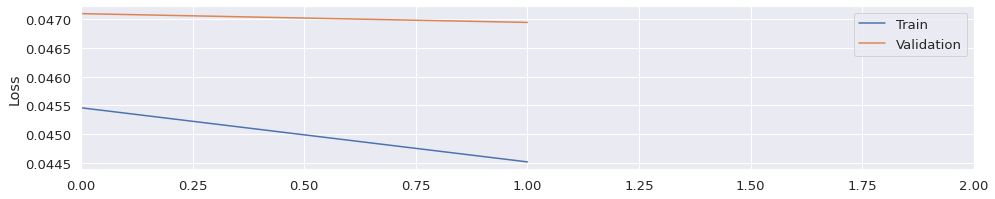

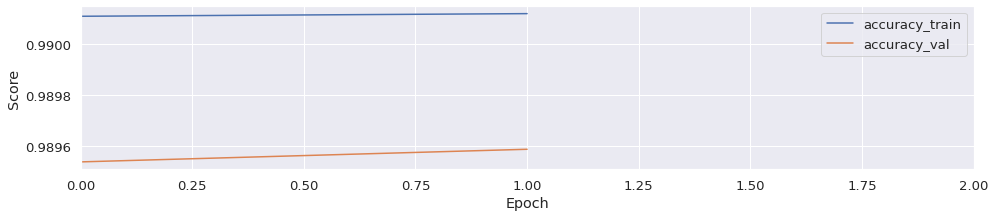

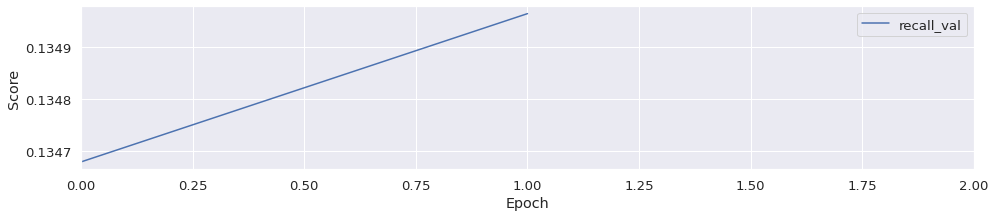

Epoch 2


  0%|          | 0/24501 [00:00<?, ?it/s]

Accuracy epoch: 98.96%


In [ ]:
info = train(model, epochs=10, calc_recall=True, checkpoint=True)

## Prediction

In [ ]:
best_model = info[0]

In [ ]:
path = 'checkpoints/recanet_dunnhumby_20.pth'
torch.save(best_model.state_dict(), path)


In [ ]:
model

ReCaNet(
  (item_embedding): Embedding(36964, 128)
  (user_embedding): Embedding(2498, 32)
  (fc1): Linear(in_features=160, out_features=128, bias=True)
  (fc2): Linear(in_features=129, out_features=128, bias=True)
  (lstm1): LSTM(128, 128, num_layers=2, batch_first=True)
  (fc5): Linear(in_features=128, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
model.load_state_dict(torch.load('checkpoints/epoch1_recanet_dunnhumby_20.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
best_model = model

In [ ]:
def predict(model, test_loader):
    
    test_items, test_users, test_history2, test_labels = dataset.create_test_data('test')
    preds = []
    pred_scores = []
    
    for x1, x2,  x4, y in tqdm(test_loader):
        with torch.no_grad():
            y_pred = model(x1, x2, x4)
            pred = [round(value) for value in y_pred.flatten().tolist()]
            preds.extend(pred)
            pred_scores.extend(y_pred.flatten().tolist())
            
   
    prediction_baskets = {}
    prediction_scores = {}
    for user in dataset.test_users:
        top_items = []
        if user in dataset.user_id_mapper:
            user_id = dataset.user_id_mapper[user]
            indices = np.argwhere(test_users == user_id)
            item_scores = np.array(pred_scores)[indices].flatten()
            item_ids = test_items[indices].flatten()
            item_score_dic = {}
            for i, item_id in enumerate(item_ids):
                item_score_dic[dataset.id_item_mapper[item_id]] = item_scores[i]
            sorted_item_scores = sorted(item_score_dic.items(), key= lambda x: x[1], reverse = True)
            top_items = [x[0] for x in sorted_item_scores]
            prediction_scores[user] = sorted_item_scores
            
        prediction_baskets[user] = top_items

    return prediction_baskets

In [ ]:
test_baskets = pd.read_csv(path_test)
user_test_baskets_df = test_baskets.groupby('user_id')['item_id'].apply(list).reset_index()
user_test_baskets_dict = dict(zip( user_test_baskets_df['user_id'],user_test_baskets_df['item_id']))

user_predictions = predict(best_model, test_loader)
final_users = set(dataset.test_users).intersection(set(list(user_test_baskets_dict.keys())))
print('predictions ready',len(user_predictions))
print('number of final test users:',len(final_users))
for k in [5,10,20,'B']:
    print(k)
    recall_scores = {}
    ndcg_scores = {}
    #zero = 0
    for user in final_users:

        top_items = []
        if user in user_predictions:
            top_items = user_predictions[user]
        else:
            zero+=1

        if k == 'B':
            recall_scores[user] = recall_k(user_test_baskets_dict[user],top_items,len(user_test_baskets_dict[user]))
            ndcg_scores[user] = ndcg_k(user_test_baskets_dict[user],top_items,len(user_test_baskets_dict[user]))
        else:
            recall_scores[user] = recall_k(user_test_baskets_dict[user],top_items,k)
            ndcg_scores[user] = ndcg_k(user_test_baskets_dict[user],top_items,k)
    #print(zero)
    print('recall:',np.mean(list(recall_scores.values())))
    print('ndcg:',np.mean(list(ndcg_scores.values())))

  0%|          | 0/322 [00:00<?, ?it/s]

predictions ready 2483
number of final test users: 1243
5
recall: 0.1250107936643539
ndcg: 0.18918372331486383
10
recall: 0.16716307337816846
ndcg: 0.15559064113478038
20
recall: 0.21960974878551262
ndcg: 0.1223453678741475
B
recall: 0.1368036419199789
ndcg: 0.1576091195917918
